In [1]:
import pandas as pd

# Cargar los datasets
movies_df = pd.read_csv("../data/movies_dataset.csv")
users_test_df = pd.read_csv("../data/users_test.csv")

users_test_df = users_test_df.drop("Unnamed: 0", axis=1)

# Mostrar información general de los datasets
print("-- Dataset movies ---")
print("\n-- info ---")
print(movies_df.info())
print("\n-- head ---")
print(movies_df.head())
print("\n-- describe ---")
print(movies_df.describe(include="all"))


print("\n-- Dataset test users ---")
print("\n-- info ---")
print(users_test_df.info())
print("\n-- head ---")
print(users_test_df.head(100))
print("\n-- describe ---")
print(users_test_df.describe(include="all"))

-- Dataset movies ---

-- info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4900 non-null   object
 1   user             4900 non-null   object
 2   rating           4900 non-null   int64 
 3   theme            4900 non-null   object
 4   production_year  4900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 191.5+ KB
None

-- head ---
           name     user  rating   theme  production_year
0  12 Angry Men  user169       6  Sci-Fi             2021
1  12 Angry Men  user425       9  Sci-Fi             2015
2  12 Angry Men  user321       8  Sci-Fi             2021
3  12 Angry Men  user329       4  Sci-Fi             2015
4  12 Angry Men  user303       1  Sci-Fi             2021

-- describe ---
              name     user       rating  theme  production_year
count         4900     4900  4900.000000   4

In [2]:
# Construcción de la matriz usuario-película
user_item_matrix = movies_df.pivot_table(
    index='user', 
    columns='name', 
    values='rating', 
    aggfunc='mean'  # En caso de que un usuario tenga más de una calificación para la misma película, se promedia.
)
user_item_matrix = user_item_matrix.fillna(0)

# Mostramos las primeras filas para verificar la matriz
print("Matriz usuario-película:")
print(user_item_matrix.head())


Matriz usuario-película:
name     12 Angry Men  1917  A Clockwork Orange  A Separation  Alien  Aliens  \
user                                                                           
user1             0.0   0.0                 0.0           0.0    0.0     0.0   
user10            0.0   0.0                 0.0           0.0    0.0     0.0   
user100           0.0   0.0                 0.0           0.0    0.0     0.0   
user103           0.0   2.0                 6.0           6.0    4.0     9.0   
user104           0.0   0.0                 0.0           0.0    0.0     0.0   

name     American History X  Amélie  Apocalypse Now  Avengers: Infinity War  \
user                                                                          
user1                   0.0     0.0             0.0                     0.0   
user10                  0.0     0.0             0.0                     0.0   
user100                 0.0     0.0             0.0                     0.0   
user103            

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud entre usuarios utilizando la similitud coseno
user_similarity = cosine_similarity(user_item_matrix)

# Convertir la matriz de similitud en un DataFrame para una mejor interpretación
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Mostrar las primeras filas de la matriz de similitud
print("Matriz de similitud entre usuarios:")
print(user_similarity_df.head())


Matriz de similitud entre usuarios:
user     user1  user10  user100   user103   user104   user105   user107  \
user                                                                      
user1      1.0     0.0      0.0  0.000000  0.000000  0.000000  0.000000   
user10     0.0     1.0      0.0  0.000000  0.000000  0.747409  0.000000   
user100    0.0     0.0      1.0  0.000000  0.000000  0.000000  0.000000   
user103    0.0     0.0      0.0  1.000000  0.019811  0.013162  0.079243   
user104    0.0     0.0      0.0  0.019811  1.000000  0.664364  0.000000   

user      user108    user11   user111  ...    user86    user87    user88  \
user                                   ...                                 
user1    0.000000  0.000000  0.222375  ...  0.707107  0.000000  0.000000   
user10   0.000000  0.000000  0.148250  ...  0.000000  0.000000  0.000000   
user100  0.000000  0.000000  0.074125  ...  0.000000  0.000000  0.000000   
user103  0.079243  0.047565  0.035243  ...  0.056033  0.13

In [8]:
# Función para predecir las top n películas para un usuario dado
def predict_top_n_for_user(user_id, user_item_matrix, user_similarity_df, n=3):
    # Si el usuario no está en la matriz, retornamos una lista vacía
    if user_id not in user_item_matrix.index:
        return []
    
    # Obtener las similitudes del usuario con los demás
    sim_scores = user_similarity_df.loc[user_id]
    
    # Obtener las películas que el usuario ya ha calificado
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()
    
    predicted_ratings = {}
    
    # Iterar sobre cada película
    for movie in user_item_matrix.columns:
        # Saltamos las películas que ya ha calificado el usuario
        if movie in rated_movies:
            continue
        
        # Calificaciones de otros usuarios para la película
        ratings = user_item_matrix[movie]
        # Consideramos solo usuarios que hayan calificado la película (rating > 0)
        mask = ratings > 0
        if mask.sum() == 0:
            continue  # No hay calificaciones, saltamos la película
        
        # Extraemos similitudes y calificaciones de los usuarios que calificaron la película
        sims = sim_scores[mask]
        other_ratings = ratings[mask]
        
        # Predicción: promedio ponderado por similitud
        if sims.sum() > 0:
            pred_rating = (sims * other_ratings).sum() / sims.sum()
        else:
            pred_rating = 0
        
        predicted_ratings[movie] = pred_rating
    
    # Ordenar las películas por calificación predicha y seleccionar las top n
    sorted_movies = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    top_movies = [movie for movie, score in sorted_movies[:n]]
    return top_movies

# Iterar sobre cada usuario en el conjunto de prueba y obtener las recomendaciones
predictions = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_for_user(user, user_item_matrix, user_similarity_df, n=3)
    predictions[user] = top_movies

# Mostrar algunas predicciones para ver el resultado
print("Predicciones (Top 3 películas) para algunos usuarios:")
for user, movies in list(predictions.items())[:5]:
    print(f"{user}: {movies}")


Predicciones (Top 3 películas) para algunos usuarios:
user169: []
user425: ['A Separation', 'Once Upon a Time in America', 'The Silence of the Lambs']
user321: ['Once Upon a Time in America', 'A Separation', 'The Silence of the Lambs']
user329: ['Once Upon a Time in America', 'A Separation', 'The Silence of the Lambs']
user303: ['A Separation', 'Once Upon a Time in America', 'Memento']


In [10]:
import numpy as np

def predict_top_n_for_user(user_id, user_item_matrix, user_similarity_df, n=3):
    # Si el usuario no está en la matriz, retornamos una lista vacía
    if user_id not in user_item_matrix.index:
        return []
    
    # Obtener las similitudes del usuario con los demás
    sim_scores = user_similarity_df.loc[user_id]
    
    # Obtener las películas que el usuario ya ha calificado
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()
    
    predicted_ratings = {}
    
    # Iterar sobre cada película
    for movie in user_item_matrix.columns:
        # Saltamos las películas que ya ha calificado el usuario
        if movie in rated_movies:
            continue
        
        # Calificaciones de otros usuarios para la película
        ratings = user_item_matrix[movie]
        # Consideramos solo usuarios que hayan calificado la película (rating > 0)
        mask = ratings > 0
        if mask.sum() == 0:
            continue  # No hay calificaciones, saltamos la película
        
        # Extraer similitudes y calificaciones de los usuarios que calificaron la película
        sims = sim_scores[mask]
        other_ratings = ratings[mask]
        
        # Predicción: promedio ponderado por similitud
        if sims.sum() > 0:
            pred_rating = (sims * other_ratings).sum() / sims.sum()
        else:
            pred_rating = 0
        
        predicted_ratings[movie] = pred_rating
    
    # Si no se obtuvieron predicciones, aplicar fallback basado en popularidad global
    if not predicted_ratings:
        print(f"Usuario {user_id} no tiene predicciones basadas en similitud. Aplicando fallback global.")
        # Calcular la calificación promedio global para cada película (ignorando ceros)
        global_avg = user_item_matrix.replace(0, np.NaN).mean()
        # Ordenar las películas por promedio de calificación en forma descendente
        sorted_global = global_avg.sort_values(ascending=False)
        # Excluir las películas ya vistas
        fallback_movies = [movie for movie in sorted_global.index if movie not in rated_movies]
        # Si el usuario ya vio todas las películas, no queda fallback sin excluir;
        # entonces, para asegurarnos de retornar n recomendaciones, usamos todas las películas globales.
        if len(fallback_movies) < n:
            print(f"Usuario {user_id} ya ha visto casi todas las películas. Se recomiendan las top globales, incluso si ya fueron vistas.")
            fallback_movies = list(sorted_global.index)
        return fallback_movies[:n]
    
    # Ordenar las películas por calificación predicha y seleccionar las top n
    sorted_movies = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    top_movies = [movie for movie, score in sorted_movies[:n]]
    return top_movies

# Iterar sobre cada usuario en el conjunto de prueba y obtener las recomendaciones
predictions = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_for_user(user, user_item_matrix, user_similarity_df, n=3)
    predictions[user] = top_movies

# Mostrar algunas predicciones para ver el resultado
print("Predicciones (Top 3 películas) para algunos usuarios:")
for user, movies in list(predictions.items())[:5]:
    print(f"{user}: {movies}")


Usuario user169 no tiene predicciones basadas en similitud. Aplicando fallback global.
Usuario user169 ya ha visto casi todas las películas. Se recomiendan las top globales, incluso si ya fueron vistas.
Usuario user375 no tiene predicciones basadas en similitud. Aplicando fallback global.
Usuario user375 ya ha visto casi todas las películas. Se recomiendan las top globales, incluso si ya fueron vistas.
Usuario user180 no tiene predicciones basadas en similitud. Aplicando fallback global.
Usuario user180 ya ha visto casi todas las películas. Se recomiendan las top globales, incluso si ya fueron vistas.
Usuario user407 no tiene predicciones basadas en similitud. Aplicando fallback global.
Usuario user407 ya ha visto casi todas las películas. Se recomiendan las top globales, incluso si ya fueron vistas.
Predicciones (Top 3 películas) para algunos usuarios:
user169: ['The Lion King', 'A Separation', 'Memento']
user425: ['A Separation', 'Once Upon a Time in America', 'The Silence of the Lam

---

In [11]:
import numpy as np

def predict_top_n_for_user(user_id, user_item_matrix, user_similarity_df, n=3):
    # Si el usuario no está en la matriz, retornamos una lista vacía
    if user_id not in user_item_matrix.index:
        return []
    
    # Obtener las similitudes del usuario con los demás
    sim_scores = user_similarity_df.loc[user_id]
    
    # Obtener las películas que el usuario ya ha calificado
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()
    
    predicted_ratings = {}
    
    # Iterar sobre cada película para calcular la predicción basada en similitud
    for movie in user_item_matrix.columns:
        # Saltamos las películas que ya ha calificado el usuario
        if movie in rated_movies:
            continue
        
        # Calificaciones de otros usuarios para la película
        ratings = user_item_matrix[movie]
        mask = ratings > 0  # Consideramos solo usuarios que han calificado la película
        
        if mask.sum() == 0:
            continue  # No hay calificaciones, saltamos la película
        
        # Extraer similitudes y calificaciones de los usuarios que calificaron la película
        sims = sim_scores[mask]
        other_ratings = ratings[mask]
        
        # Predicción: promedio ponderado por similitud
        if sims.sum() > 0:
            pred_rating = (sims * other_ratings).sum() / sims.sum()
        else:
            pred_rating = 0
        
        predicted_ratings[movie] = pred_rating
    
    # Inicialmente, obtenemos las top n recomendaciones del filtrado colaborativo (si hay)
    top_movies = []
    if predicted_ratings:
        sorted_movies = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
        top_movies = [movie for movie, score in sorted_movies[:n]]
    
    # Si no alcanzamos n recomendaciones, se completa con un fallback global
    if len(top_movies) < n:
        print(f"Usuario {user_id} no tiene suficientes predicciones basadas en similitud. Aplicando fallback global para completar las recomendaciones.")
        # Calcular el promedio global de cada película (ignorando ceros)
        global_avg = user_item_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        
        # Primero, buscar películas que no haya visto y que aún no estén en top_movies
        fallback_movies = [movie for movie in global_avg.index if movie not in rated_movies and movie not in top_movies]
        
        # Si aún faltan recomendaciones, se completan con las top globales (aunque ya hayan sido vistas)
        if len(fallback_movies) < (n - len(top_movies)):
            print(f"Usuario {user_id} ya ha visto casi todas las películas. Se completan las recomendaciones con las top globales, incluso si ya fueron vistas.")
            fallback_movies = [movie for movie in global_avg.index if movie not in top_movies]
        
        # Completar hasta tener n recomendaciones
        top_movies += fallback_movies[:(n - len(top_movies))]
    
    return top_movies

# Iterar sobre cada usuario en el conjunto de prueba y obtener las recomendaciones
predictions = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_for_user(user, user_item_matrix, user_similarity_df, n=3)
    predictions[user] = top_movies

# Mostrar algunas predicciones para ver el resultado
print("Predicciones (Top 3 películas) para algunos usuarios:")
for user, movies in list(predictions.items())[:5]:
    print(f"{user}: {movies}")


Usuario user169 no tiene suficientes predicciones basadas en similitud. Aplicando fallback global para completar las recomendaciones.
Usuario user169 ya ha visto casi todas las películas. Se completan las recomendaciones con las top globales, incluso si ya fueron vistas.
Usuario user375 no tiene suficientes predicciones basadas en similitud. Aplicando fallback global para completar las recomendaciones.
Usuario user375 ya ha visto casi todas las películas. Se completan las recomendaciones con las top globales, incluso si ya fueron vistas.
Usuario user180 no tiene suficientes predicciones basadas en similitud. Aplicando fallback global para completar las recomendaciones.
Usuario user180 ya ha visto casi todas las películas. Se completan las recomendaciones con las top globales, incluso si ya fueron vistas.
Usuario user407 no tiene suficientes predicciones basadas en similitud. Aplicando fallback global para completar las recomendaciones.
Usuario user407 ya ha visto casi todas las películ

In [12]:
import json

# Estructura requerida: las predicciones dentro de la clave "target"
output = {"target": predictions}

# Guardar el archivo JSON
with open("../predictions/predictions.json", "w") as f:
    json.dump(output, f, indent=4)

print("Archivo predictions.json guardado correctamente.")


Archivo predictions.json guardado correctamente.


356/900 puntos

---

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 1. Función para crear la matriz normalizada y obtener el baseline de cada usuario
def create_normalized_matrix(user_item_matrix, method='mean'):
    """
    Crea una matriz normalizada y calcula el baseline (media o mediana) de cada usuario.
    
    Parámetros:
      - user_item_matrix: DataFrame original (usuarios x películas) con ratings.
      - method: 'mean' o 'median'
    
    Retorna:
      - norm_matrix: matriz normalizada (solo se resta el baseline en las entradas valoradas).
      - baseline: diccionario con baseline por usuario.
    """
    baseline = {}
    norm_matrix = user_item_matrix.copy()
    for user in norm_matrix.index:
        # Consideramos solo las calificaciones > 0 (las no calificadas son 0)
        rated = norm_matrix.loc[user] > 0
        if rated.sum() > 0:
            if method == 'mean':
                b = norm_matrix.loc[user][rated].mean()
            elif method == 'median':
                b = norm_matrix.loc[user][rated].median()
            else:
                raise ValueError("Method must be 'mean' or 'median'")
        else:
            b = 0
        baseline[user] = b
        # Para cada película: si rating > 0, normalizamos (rating - baseline); sino, dejamos 0.
        norm_matrix.loc[user] = norm_matrix.loc[user].apply(lambda x: (x - b) if x > 0 else 0)
    return norm_matrix, baseline

# Crear las matrices normalizadas: una con media y otra con mediana
norm_matrix_mean, baseline_mean = create_normalized_matrix(user_item_matrix, method='mean')
norm_matrix_median, baseline_median = create_normalized_matrix(user_item_matrix, method='median')

# 2. Calcular la similitud usando la matriz normalizada
similarity_mean = cosine_similarity(norm_matrix_mean)
similarity_df_mean = pd.DataFrame(similarity_mean, index=norm_matrix_mean.index, columns=norm_matrix_mean.index)

similarity_median = cosine_similarity(norm_matrix_median)
similarity_df_median = pd.DataFrame(similarity_median, index=norm_matrix_median.index, columns=norm_matrix_median.index)

# 3. Función para predecir recomendaciones usando la normalización
def predict_top_n_for_user_normalized(user_id, norm_matrix, baseline, similarity_df, original_matrix, n=3):
    """
    Para un usuario dado, predice la calificación de las películas no vistas usando la matriz normalizada,
    y luego le suma el baseline para obtener la predicción en la escala original.
    
    Parámetros:
      - user_id: identificador del usuario.
      - norm_matrix: matriz normalizada (deviaciones).
      - baseline: diccionario con baseline por usuario.
      - similarity_df: DataFrame de similitud entre usuarios (calculada sobre la matriz normalizada).
      - original_matrix: matriz original de ratings (para identificar las películas ya vistas).
      - n: número de recomendaciones a devolver.
    
    Retorna:
      - top_movies: lista con los nombres de las top n películas recomendadas.
    """
    if user_id not in norm_matrix.index:
        return []
    sim_scores = similarity_df.loc[user_id]
    # Películas ya calificadas (usamos la matriz original)
    rated_movies = original_matrix.loc[user_id][original_matrix.loc[user_id] > 0].index.tolist()
    
    predicted_ratings = {}
    for movie in norm_matrix.columns:
        if movie in rated_movies:
            continue  # ya fue vista
        ratings = norm_matrix[movie]
        # Usamos aquellos usuarios que hayan calificado la película (donde el valor normalizado no es 0)
        mask = ratings != 0
        if mask.sum() == 0:
            continue
        sims = sim_scores[mask]
        other_norm_ratings = ratings[mask]
        if sims.sum() > 0:
            pred_norm = (sims * other_norm_ratings).sum() / sims.sum()
        else:
            pred_norm = 0
        # Predicción en escala original: baseline + predicción normalizada
        pred_rating = baseline[user_id] + pred_norm
        predicted_ratings[movie] = pred_rating
    
    top_movies = []
    if predicted_ratings:
        sorted_movies = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
        top_movies = [movie for movie, score in sorted_movies[:n]]
    
    # Si faltan recomendaciones, completar con fallback global (usando la matriz original)
    if len(top_movies) < n:
        print(f"Usuario {user_id} no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.")
        global_avg = original_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        fallback_movies = [movie for movie in global_avg.index if movie not in rated_movies and movie not in top_movies]
        if len(fallback_movies) < (n - len(top_movies)):
            fallback_movies = [movie for movie in global_avg.index if movie not in top_movies]
        top_movies += fallback_movies[:(n - len(top_movies))]
    return top_movies

# 4. Generar las predicciones para cada usuario usando ambas normalizaciones

# Usando normalización por MEDIA
predictions_mean = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_for_user_normalized(user, norm_matrix_mean, baseline_mean, similarity_df_mean, user_item_matrix, n=3)
    predictions_mean[user] = top_movies

# Usando normalización por MEDIANA
predictions_median = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_for_user_normalized(user, norm_matrix_median, baseline_median, similarity_df_median, user_item_matrix, n=3)
    predictions_median[user] = top_movies

# Mostrar algunas predicciones para comparar
print("Predicciones (Normalización por MEDIA):")
for user, movies in list(predictions_mean.items())[:5]:
    print(f"{user}: {movies}")

print("\nPredicciones (Normalización por MEDIANA):")
for user, movies in list(predictions_median.items())[:5]:
    print(f"{user}: {movies}")


Usuario user169 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user375 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user180 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user407 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user169 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user375 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user180 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomendaciones.
Usuario user407 no tiene suficientes predicciones normalizadas. Aplicando fallback global para completar las recomenda

In [16]:
import json

# Guardar el JSON para normalización por MEDIA
output_mean = {"target": predictions_mean}
with open("../predictions/predictions_mean.json", "w") as f:
    json.dump(output_mean, f, indent=4)
print("Archivo 'predictions_mean.json' guardado correctamente.")

# Guardar el JSON para normalización por MEDIANA
output_median = {"target": predictions_median}
with open("../predictions/predictions_median.json", "w") as f:
    json.dump(output_median, f, indent=4)
print("Archivo 'predictions_median.json' guardado correctamente.")


Archivo 'predictions_mean.json' guardado correctamente.
Archivo 'predictions_median.json' guardado correctamente.


- Archivo 'predictions_mean.json'     : 112/900 puntos (descartado)
- Archivo 'predictions_median.json'   : 90/900 puntos (descartado)

---

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# 1. Construir el DataFrame de características para cada película
# Obtenemos los registros únicos de películas (ya que en movies_df hay varias filas para la misma película)
movies_unique = movies_df[['name', 'theme', 'production_year']].drop_duplicates(subset='name').set_index('name')

# One-Hot Encoding para la columna 'theme'
movies_features = pd.get_dummies(movies_unique, columns=['theme'])

# Escalar 'production_year'
scaler = StandardScaler()
movies_features['production_year'] = scaler.fit_transform(movies_features[['production_year']])

# 2. Calcular la matriz de similitud de contenido entre películas usando cosine similarity
movie_content_sim = cosine_similarity(movies_features)
movie_content_sim_df = pd.DataFrame(movie_content_sim, index=movies_features.index, columns=movies_features.index)

# 3. Función para predecir recomendaciones basadas en contenido para un usuario
def predict_top_n_content_for_user(user_id, user_item_matrix, movie_content_sim_df, n=3):
    """
    Para un usuario dado, genera recomendaciones basadas en contenido.
    
    Para cada película no vista, se calcula una puntuación:
      - Se recorre cada película que el usuario ya ha calificado (con rating > 0)
      - Se usa la similitud entre la película candidata y la calificada,
        ponderándola por la calificación dada.
      - Se suma y se divide por la suma de similitudes para obtener un score.
    
    Retorna:
      - top_movies: lista de las top n películas recomendadas.
    """
    if user_id not in user_item_matrix.index:
        return []
    
    # Películas que el usuario ya ha calificado (usamos el dataframe original)
    rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0]
    if rated_movies.empty:
        return []  # Si el usuario no tiene calificaciones, no podemos recomendar basándonos en contenido
    
    # Lista de películas candidatas (aquellas que el usuario NO ha calificado)
    candidate_movies = [m for m in movie_content_sim_df.index if m not in rated_movies.index]
    
    scores = {}
    for candidate in candidate_movies:
        numerator = 0
        denominator = 0
        # Iterar sobre las películas calificadas por el usuario
        for rated_movie, rating in rated_movies.items():
            sim = movie_content_sim_df.loc[candidate, rated_movie]
            numerator += sim * rating
            denominator += sim
        score = numerator / denominator if denominator != 0 else 0
        scores[candidate] = score
    
    # Ordenar las películas candidatas según el score (descendente)
    sorted_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_movies = [movie for movie, score in sorted_movies[:n]]
    
    return top_movies

# 4. Generar las predicciones basadas en contenido para cada usuario en el conjunto de prueba
predictions_content = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_content_for_user(user, user_item_matrix, movie_content_sim_df, n=3)
    # Si por alguna razón no hay suficientes recomendaciones, completamos con fallback global
    if len(top_movies) < 3:
        global_avg = user_item_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        fallback_movies = [m for m in global_avg.index if m not in top_movies]
        top_movies += fallback_movies[:(3 - len(top_movies))]
    predictions_content[user] = top_movies

# Mostrar algunas predicciones para ver el resultado
print("Predicciones (Basadas en Contenido):")
for user, movies in list(predictions_content.items())[:5]:
    print(f"{user}: {movies}")


Predicciones (Basadas en Contenido):
user169: ['The Lion King', 'A Separation', 'Memento']
user425: ['Requiem for a Dream', 'Django Unchained', 'Psycho']
user321: ['Requiem for a Dream', 'Django Unchained', "One Flew Over the Cuckoo's Nest"]
user329: ['Modern Times', 'Apocalypse Now', 'Fight Club']
user303: ['Modern Times', 'Apocalypse Now', 'Capernaum']


In [19]:
import json

output = {"target": predictions_content}
with open("../predictions/predictions.json", "w") as f:
    json.dump(output, f, indent=4)
print("Archivo 'predictions.json' guardado correctamente.")

Archivo 'predictions.json' guardado correctamente.


One-Hot encoding theme, scalar prodution_year: 113/900 puntos

---

In [21]:
def predict_scores_cf(user_id, user_item_matrix, similarity_df, baseline, n=3):
    """
    Retorna un diccionario con las predicciones de CF (normalizado) para cada película no vista por el usuario.
    Se utiliza la matriz original (user_item_matrix) para identificar las películas ya vistas.
    """
    if user_id not in user_item_matrix.index:
        return {}
    
    sim_scores = similarity_df.loc[user_id]
    rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index.tolist()
    
    predicted_scores = {}
    for movie in user_item_matrix.columns:
        if movie in rated_movies:
            continue
        
        # Obtenemos las calificaciones normalizadas para la película de otros usuarios
        # Para este ejemplo, supongamos que disponemos de la versión normalizada CF ya calculada
        # (La función predict_top_n_for_user_normalized calcula la predicción sumándole el baseline)
        # Aquí vamos a replicar la lógica para obtener el score.
        ratings = norm_matrix_mean[movie]  # Usamos la normalización por MEDIA, por ejemplo.
        mask = ratings != 0
        if mask.sum() == 0:
            continue
        sims = sim_scores[mask]
        other_norm_ratings = ratings[mask]
        if sims.sum() > 0:
            pred_norm = (sims * other_norm_ratings).sum() / sims.sum()
        else:
            pred_norm = 0
        # Predicción en escala original
        pred_cf = baseline[user_id] + pred_norm
        predicted_scores[movie] = pred_cf
    return predicted_scores

def predict_scores_content(user_id, user_item_matrix, movie_content_sim_df):
    """
    Retorna un diccionario con las predicciones basadas en contenido para cada película no vista por el usuario.
    """
    if user_id not in user_item_matrix.index:
        return {}
    
    rated_movies_series = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0]
    if rated_movies_series.empty:
        return {}
    
    rated_movies = rated_movies_series.index.tolist()
    candidate_movies = [m for m in movie_content_sim_df.index if m not in rated_movies]
    
    scores = {}
    for candidate in candidate_movies:
        numerator = 0
        denominator = 0
        for rated_movie, rating in rated_movies_series.items():
            sim = movie_content_sim_df.loc[candidate, rated_movie]
            numerator += sim * rating
            denominator += sim
        score = numerator / denominator if denominator != 0 else 0
        scores[candidate] = score
    return scores

def combine_predictions(user_id, user_item_matrix, similarity_df, baseline, movie_content_sim_df, alpha=0.5, n=3):
    """
    Combina las predicciones de CF y contenido para un usuario, usando el parámetro alpha.
    Retorna una lista con las top n recomendaciones.
    """
    cf_scores = predict_scores_cf(user_id, user_item_matrix, similarity_df, baseline, n)
    content_scores = predict_scores_content(user_id, user_item_matrix, movie_content_sim_df)
    
    # Unir las claves de ambas predicciones
    all_candidates = set(cf_scores.keys()).union(set(content_scores.keys()))
    combined_scores = {}
    for movie in all_candidates:
        score_cf = cf_scores.get(movie, None)
        score_content = content_scores.get(movie, None)
        
        # Si ambos modelos tienen un score, combinamos.
        if score_cf is not None and score_content is not None:
            combined = alpha * score_cf + (1 - alpha) * score_content
        elif score_cf is not None:
            combined = score_cf
        elif score_content is not None:
            combined = score_content
        else:
            continue
        combined_scores[movie] = combined
    
    # Ordenar las películas candidatas según el score combinado (descendente)
    sorted_movies = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    top_movies = [movie for movie, score in sorted_movies[:n]]
    
    # Fallback en caso de que no se alcancen n recomendaciones
    if len(top_movies) < n:
        global_avg = user_item_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        fallback_movies = [m for m in global_avg.index if m not in top_movies]
        top_movies += fallback_movies[:(n - len(top_movies))]
    return top_movies

# Generar las predicciones híbridas para cada usuario del conjunto de prueba.
predictions_hybrid = {}
alpha = 0.5  # Ajustable según pruebas
for user in users_test_df["user"]:
    top_movies = combine_predictions(user, user_item_matrix, similarity_df_mean, baseline_mean, movie_content_sim_df, alpha=alpha, n=3)
    predictions_hybrid[user] = top_movies

# Mostrar algunas predicciones híbridas
print("Predicciones Híbridas (CF + Contenido) con alpha=0.5:")
for user, movies in list(predictions_hybrid.items())[:5]:
    print(f"{user}: {movies}")


Predicciones Híbridas (CF + Contenido) con alpha=0.5:
user169: ['The Lion King', 'A Separation', 'Memento']
user425: ['Requiem for a Dream', 'Django Unchained', 'Forrest Gump']
user321: ['Requiem for a Dream', 'Django Unchained', "One Flew Over the Cuckoo's Nest"]
user329: ['Modern Times', 'Apocalypse Now', 'Capernaum']
user303: ['Modern Times', 'Apocalypse Now', 'Capernaum']


In [22]:
import json

output = {"target": predictions_hybrid}
with open("../predictions/predictions.json", "w") as f:
    json.dump(output, f, indent=4)
print("Archivo 'predictions.json' guardado correctamente.")

Archivo 'predictions.json' guardado correctamente.


118/900 puntos.

---

SVD

In [35]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# 1. Aplicar Truncated SVD a la matriz usuario‑película
# Vamos a elegir un número de componentes (k). Este hiperparámetro se puede ajustar.
n_components = 40  # Puedes experimentar con este valor

# Instanciar y ajustar el modelo SVD sobre la matriz (ya tiene 0 para no calificado)
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(user_item_matrix)

# Obtener la representación latente
# U: transformamos la matriz original (n_users x k)
U = svd.transform(user_item_matrix)  # Shape: (n_users, n_components)
# S: los valores singulares (vector de tamaño n_components)
S = svd.singular_values_
# V^T: componentes del SVD (n_components x n_movies)
Vt = svd.components_

# Reconstruir la matriz de predicción
R_hat = np.dot(U, np.dot(np.diag(S), Vt))
# Convertir a DataFrame, usando los índices y columnas de la matriz original
R_hat_df = pd.DataFrame(R_hat, index=user_item_matrix.index, columns=user_item_matrix.columns)

# 2. Función para obtener las top n recomendaciones para un usuario usando SVD
def predict_top_n_SVD_for_user(user_id, user_item_matrix, R_hat_df, n=3):
    """
    Para un usuario dado, predice las 3 películas no calificadas con mayor puntuación
    usando la reconstrucción de la matriz a partir del SVD.
    """
    if user_id not in user_item_matrix.index:
        return []
    
    # Obtener las películas ya calificadas por el usuario (rating > 0)
    rated_movies = user_item_matrix.loc[user_id]
    rated_movies = rated_movies[rated_movies > 0].index.tolist()
    
    # Predicciones del modelo para el usuario
    predictions = R_hat_df.loc[user_id]
    
    # Excluir las películas que ya fueron calificadas
    predictions = predictions.drop(labels=rated_movies)
    
    # Ordenar las predicciones de mayor a menor
    sorted_predictions = predictions.sort_values(ascending=False)
    top_movies = sorted_predictions.head(n).index.tolist()
    
    return top_movies

# 3. Generar las predicciones para cada usuario en el conjunto de prueba
predictions_SVD = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_SVD_for_user(user, user_item_matrix, R_hat_df, n=3)
    # En caso de que por algún motivo se tenga menos de 3 (muy poco probable), se completa con fallback global.
    if len(top_movies) < 3:
        global_avg = user_item_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        fallback_movies = [m for m in global_avg.index if m not in top_movies]
        top_movies += fallback_movies[:(3 - len(top_movies))]
    predictions_SVD[user] = top_movies

# 4. Mostrar algunas predicciones
print("Predicciones (Modelo SVD):")
for user, movies in list(predictions_SVD.items())[:5]:
    print(f"{user}: {movies}")


Predicciones (Modelo SVD):
user169: ['The Lion King', 'A Separation', 'Memento']
user425: ['Fight Club', 'Spirited Away', 'Saving Private Ryan']
user321: ['Saving Private Ryan', 'Fight Club', 'Spirited Away']
user329: ['Fight Club', 'Saving Private Ryan', 'Spirited Away']
user303: ['Saving Private Ryan', 'Spirited Away', 'Fight Club']


In [36]:
import json

output = {"target": predictions_SVD}
with open("../predictions/predictions.json", "w") as f:
    json.dump(output, f, indent=4)
print("Archivo 'predictions.json' guardado correctamente.")

Archivo 'predictions.json' guardado correctamente.


- n=50 --> 183/900
- n=40 --> 185/900
- n=30 --> 197/900
- n=10 --> 189/900
- n = 5  --> 164/900

---

In [38]:
# --- Paso 1: Características de contenido ---
# Supongamos que 'movies_df' tiene las columnas: name, theme, production_year
movies_unique = movies_df[['name', 'theme', 'production_year']].drop_duplicates(subset='name').set_index('name')
movies_features = pd.get_dummies(movies_unique, columns=['theme'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
movies_features['production_year'] = scaler.fit_transform(movies_features[['production_year']])

# movies_features es nuestro DataFrame de características para cada película.

# --- Paso 2: Obtener vectores latentes con SVD++ ---
# Usaremos la librería Surprise (si no la tienes, instálala con: pip install scikit-surprise)
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import train_test_split

# Preparamos el dataset para Surprise
# Asumimos que 'movies_df' tiene las columnas: user, name, rating
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(movies_df[['user', 'name', 'rating']], reader)
trainset = data.build_full_trainset()

# Entrenamos SVD++
algo = SVDpp(n_factors=30, random_state=42)
algo.fit(trainset)

# Obtenemos los vectores latentes para las películas
# La librería Surprise guarda el bias y los factores en algo.qi para cada item
latent_factors = {}
for item_inner_id in trainset.all_items():
    item_raw_id = trainset.to_raw_iid(item_inner_id)
    latent_factors[item_raw_id] = algo.qi[item_inner_id]
    
# Convertir a DataFrame (cada película tendrá, por ejemplo, 30 dimensiones)
latent_df = pd.DataFrame(latent_factors).T  # índice: name de la película; columnas: factor_1, factor_2, ..., factor_30
latent_df.columns = [f"svd_factor_{i}" for i in range(latent_df.shape[1])]

# --- Paso 3: Construir el dataset para LightGBM ---
# Ahora combinamos las características de contenido con los vectores latentes.
features_df = movies_features.join(latent_df, how='inner')  # Nos aseguramos de que coincidan las películas

# Ahora, para cada interacción (usuario, película), queremos formar un registro.
# Podemos crear un DataFrame 'df_train' con:
# - user_id
# - movie_id (o name)
# - rating (objetivo)
# - Las características de la película (content + latent factors)
# - (Opcional) Características del usuario

# Por ejemplo:
interactions = movies_df[['user', 'name', 'rating']].copy()
# Incorporamos las features de la película
df_train = interactions.merge(features_df, left_on='name', right_index=True, how='left')

# (Opcional) Podrías agregar features agregadas del usuario, como su promedio de rating, etc.

# --- Paso 4: Entrenar LightGBM ---
import lightgbm as lgb

# Separamos características y objetivo
X = df_train.drop(columns=['user', 'name', 'rating'])
y = df_train['rating']

# Puedes usar LGBMRegressor para predecir rating
model = lgb.LGBMRegressor(objective='regression', random_state=42)
model.fit(X, y)

# --- Paso 5: Generar Recomendaciones ---
# Para cada usuario en el conjunto de prueba, creamos un dataset con todas las películas no vistas
# y predecimos el score.

def predict_top_n_lightgbm(user_id, user_item_matrix, features_df, model, n=3):
    # Películas ya vistas por el usuario
    seen_movies = user_item_matrix.loc[user_id]
    seen_movies = seen_movies[seen_movies > 0].index.tolist()
    
    # Lista de películas candidatas: todas las que están en features_df y que no se han visto
    candidate_movies = [movie for movie in features_df.index if movie not in seen_movies]
    
    # Si no hay candidatas (usuario vio todas las películas), usamos todas las películas
    if len(candidate_movies) == 0:
        print(f"Usuario {user_id} ya ha visto todas las películas. Usando todas las películas para predicción.")
        candidate_movies = list(features_df.index)
    
    # Creamos un DataFrame para las candidatas (solo las features de la película)
    X_candidate = features_df.loc[candidate_movies].reset_index(drop=True)
    
    # Si X_candidate resulta vacío (por algún motivo), devolvemos un fallback (por ejemplo, las top globales)
    if X_candidate.shape[0] == 0:
        print(f"Usuario {user_id}: DataFrame de candidatos vacío. Aplicando fallback global.")
        global_avg = user_item_matrix.replace(0, np.NaN).mean().sort_values(ascending=False)
        fallback_movies = list(global_avg.index)[:n]
        return fallback_movies

    # Predecimos el rating (o score)
    preds = model.predict(X_candidate)
    
    # Asociamos cada película con su predicción
    scores = pd.Series(preds, index=candidate_movies)
    top_movies = scores.sort_values(ascending=False).head(n).index.tolist()
    return top_movies


# Generamos las predicciones para cada usuario de prueba:
predictions_lgbm = {}
for user in users_test_df["user"]:
    top_movies = predict_top_n_lightgbm(user, user_item_matrix, features_df, model, n=3)
    predictions_lgbm[user] = top_movies

# Finalmente, genera el JSON con el formato requerido:
import json
output = {"target": predictions_lgbm}
with open("../predictions/predictions_lightgbm_svdpp.json", "w") as f:
    json.dump(output, f, indent=4)

print("Archivo 'predictions_lightgbm_svdpp.json' generado correctamente.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 4900, number of used features: 41
[LightGBM] [Info] Start training from score 5.488367
Usuario user169 ya ha visto todas las películas. Usando todas las películas para predicción.
Usuario user375 ya ha visto todas las películas. Usando todas las películas para predicción.
Usuario user180 ya ha visto todas las películas. Usando todas las películas para predicción.
Usuario user407 ya ha visto todas las películas. Usando todas las películas para predicción.
Archivo 'predictions_lightgbm_svdpp.json' generado correctamente.


472/900

---

Estadísticas descriptivas de las features antes del escalado:
         movie_age  movie_mean_rating  movie_count_ratings  user_mean_rating  \
count  4900.000000        4900.000000          4900.000000       4900.000000   
mean     20.136735           5.488367            52.857143          5.488367   
std       9.533285           0.420288             6.999256          0.585486   
min       4.000000           4.440000            50.000000          1.000000   
25%      11.000000           5.260000            50.000000          5.250000   
50%      21.000000           5.540000            50.000000          5.500000   
75%      29.000000           5.780000            50.000000          5.704545   
max      35.000000           6.460000            70.000000         10.000000   

       user_count_ratings  user_std_rating  
count         4900.000000      4900.000000  
mean            81.542857         2.792915  
std             24.352484         0.420001  
min              1.000000         0.0

/home/pablost/Movie_Recommendation_System_Challenge/frogames-data-mlaz2/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


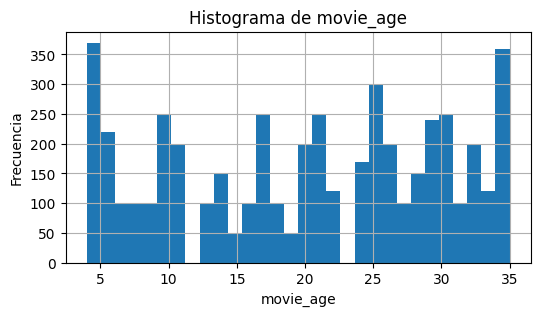

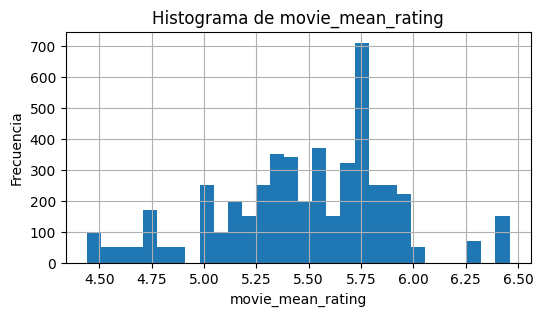

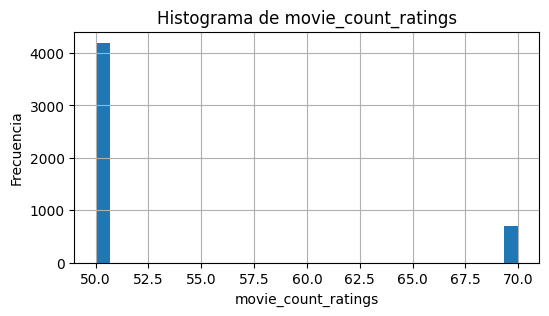

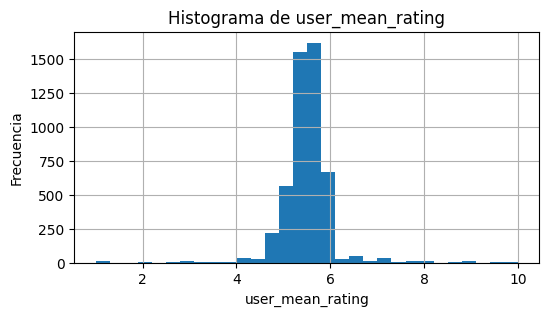

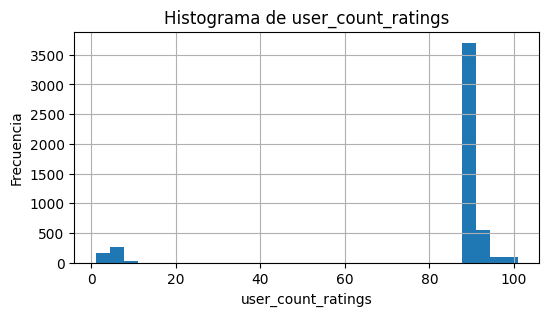

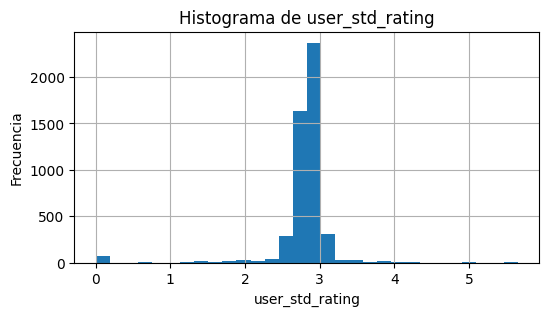


Estadísticas descriptivas de las features después del escalado:
          movie_age  movie_mean_rating  movie_count_ratings  user_mean_rating  \
count  4.900000e+03       4.900000e+03         4.900000e+03      4.900000e+03   
mean   1.421085e-16      -3.712223e-16         4.292258e-16     -4.350262e-16   
std    1.000102e+00       1.000102e+00         1.000102e+00      1.000102e+00   
min   -1.692846e+00      -2.494658e+00        -4.082483e-01     -7.666832e+00   
25%   -9.585014e-01      -5.434149e-01        -4.082483e-01     -4.071686e-01   
50%    9.056200e-02       1.228632e-01        -4.082483e-01      1.987039e-02   
75%    9.298127e-01       6.939588e-01        -4.082483e-01      3.692659e-01   
max    1.559251e+00       2.312063e+00         2.449490e+00      7.706573e+00   

       user_count_ratings  user_std_rating  
count        4.900000e+03     4.900000e+03  
mean        -3.480209e-17     7.192433e-16  
std          1.000102e+00     1.000102e+00  
min         -3.307715e+00

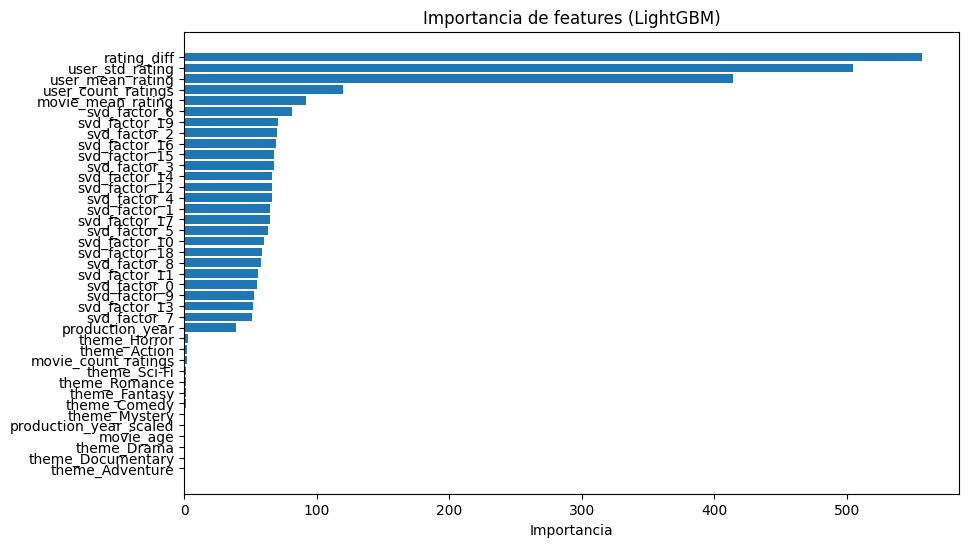

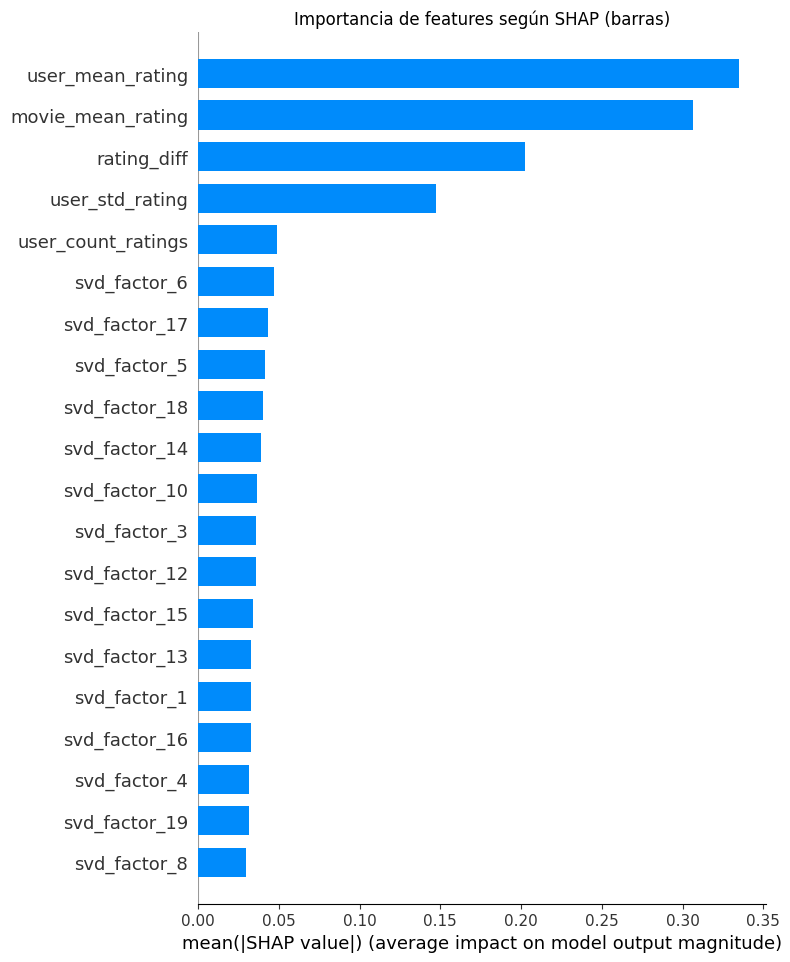

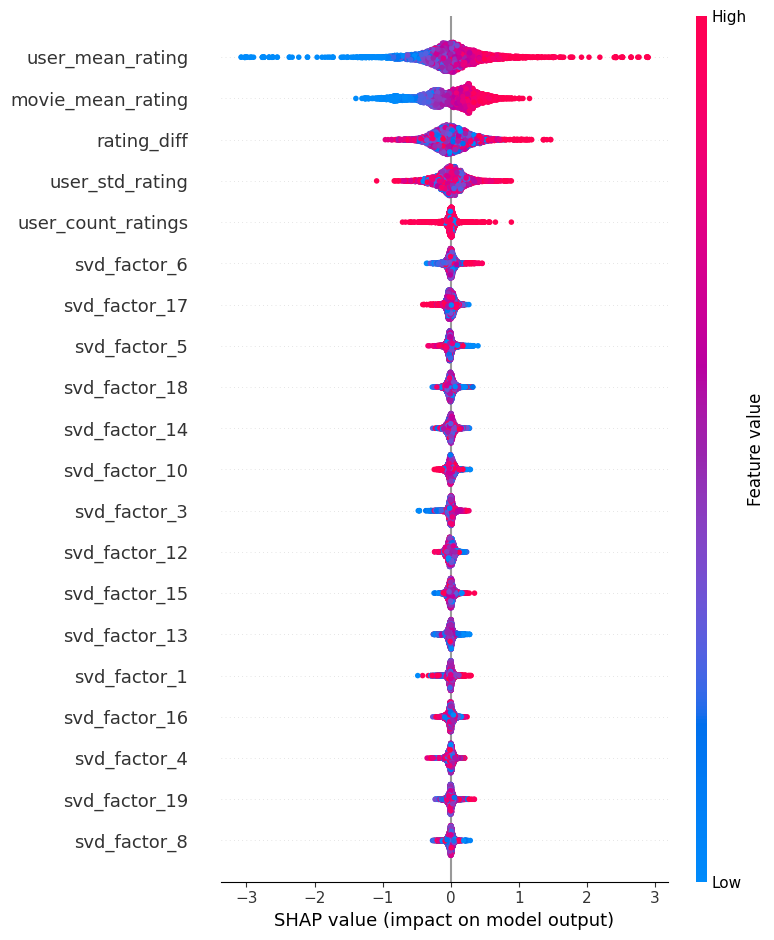

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import shap

# --- 1. Inspección de las distribuciones y rangos de las nuevas features ---

# Lista de las columnas que queremos inspeccionar
cols_to_inspect = [
    'movie_age', 
    'movie_mean_rating', 
    'movie_count_ratings', 
    'user_mean_rating', 
    'user_count_ratings', 
    'user_std_rating'
]

print("Estadísticas descriptivas de las features antes del escalado:")
print(df_train[cols_to_inspect].describe())

# Opcional: visualizar histogramas de cada feature
for col in cols_to_inspect:
    plt.figure(figsize=(6, 3))
    df_train[col].hist(bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

# --- 2. Aplicar escalado a las nuevas features ---

# Usaremos StandardScaler, pero también se puede probar MinMaxScaler según convenga.
scaler = StandardScaler()
df_train_scaled = df_train.copy()
df_train_scaled[cols_to_inspect] = scaler.fit_transform(df_train[cols_to_inspect])

print("\nEstadísticas descriptivas de las features después del escalado:")
print(df_train_scaled[cols_to_inspect].describe())

# --- 3. Entrenar el modelo LightGBM con el dataset escalado ---
# Separamos las features y el objetivo. Asumimos que df_train_scaled incluye las columnas 'user', 'name' y 'rating'
X_scaled = df_train_scaled.drop(columns=['user', 'name', 'rating'])
y = df_train_scaled['rating']

# Entrenamos LightGBM (puedes ajustar hiperparámetros si lo deseas, aquí usamos parámetros básicos)
model_scaled = lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
model_scaled.fit(X_scaled, y)

# --- 4. Análisis de importancia de features con model.feature_importances_ ---

# Extraer importancias y crear un DataFrame para visualizarlas
importances = model_scaled.feature_importances_
features = X_scaled.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("\nImportancia de las features según LightGBM:")
print(importance_df)

# Gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Importancia")
plt.title("Importancia de features (LightGBM)")
plt.gca().invert_yaxis()  # Invertir para que la feature más importante quede arriba
plt.show()

# --- 5. Análisis de importancia de features con SHAP ---
# Calcular SHAP values para nuestro modelo
explainer = shap.TreeExplainer(model_scaled)
shap_values = explainer.shap_values(X_scaled)

# Resumen de SHAP (beeswarm plot)
shap.summary_plot(shap_values, X_scaled, plot_type="bar", show=False)
plt.title("Importancia de features según SHAP (barras)")
plt.show()

# También puedes ver el summary plot tradicional:
shap.summary_plot(shap_values, X_scaled)


---